In [25]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
from astropy.io import fits, ascii
from astropy.table import Table
import os
import math

import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

In [26]:
def _getPivotsAndScales(label_vals):

    qs = np.percentile(label_vals, (2.5, 50, 97.5), axis=0)
    pivots = qs[1]
    scales = (qs[2] - qs[0])/4.

    return pivots, scales

def scaleLabels(labels):
    
    scaled_labels = []
    for i in range(labels.shape[1]):
        p, s = _getPivotsAndScales(labels.T[i])
        slbl = [(t - p)/s for t in labels.T[i]]
        scaled_labels.append(slbl)
        
    return np.array(scaled_labels).T

In [27]:
dfile = AP_PATH + '/training_sets/mann_sample/'
rfile = 'train_ref/mann_ref_labels.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = [x.split('2-')[1].split('.fits')[0] for x in ids]
tr_label = scaleLabels(ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H']))

ds = dataset.Dataset(wl, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/apogee_data/training_sets/mann_sample/
Spectra loaded


In [28]:
parrange = [[3000, 4400], [5.0, 5.0], [-0.5, 0.0]]
mdls = ap.readModels(parrange=parrange, grid='PHOENIX')

lbls = np.array([md.params for md in mdls])
phn_tr_label = np.array([lbls.T[0], lbls.T[2]]).T
tr_ID = np.array(['BTSETTL_{}_{}'.format(lbl[0], lbl[1]) for lbl in phn_tr_label])

wl = mdls[0].wave
tr_flux = np.array([md.flux for md in mdls])
tr_ivar = 1000*np.ones([len(phn_tr_label),len(wl)])

In [161]:
# pseudo_tr_flux, pseudo_tr_ivar = phn_ds.continuum_normalize_training_q(q=0.90, delta_lambda=50)
# contmask = phn_ds.make_contmask(pseudo_tr_flux, pseudo_tr_ivar, frac=0.07)
# phn_ds.set_continuum(contmask)
# cont = phn_ds.fit_continuum(3, "sinusoid")
# norm_tr_flux, norm_tr_ivar, norm_test_flux, norm_test_ivar = phn_ds.continuum_normalize(cont)

# phn_ds.tr_flux = norm_tr_flux
# phn_ds.tr_ivar = norm_tr_ivar
# phn_ds.test_flux = norm_test_flux
# phn_ds.test_ivar = norm_test_ivar

# np.save('norm_spec/phn_norm_wave', phn_ds.wl)
# np.save('norm_spec/phn_norm_ivar', norm_tr_ivar)
# np.save('norm_spec/phn_norm_flux', norm_tr_flux)
# np.save('norm_spec/phn_tr_ID', tr_ID)

In [14]:
phn_wl = np.load('norm_spec/phn_norm_wave.npy')
phn_tr_flux = np.load('norm_spec/phn_norm_flux.npy')
phn_tr_ivar = np.load('norm_spec/phn_norm_ivar.npy')
phn_tr_ID = np.load('norm_spec/phn_tr_ID.npy')

In [22]:
phn_ds = dataset.Dataset(wl, tr_ID, tr_flux, tr_ivar, phn_tr_label, tr_ID, tr_flux, tr_ivar) 
phn_ds.set_label_names(['T_{\rm eff}', '[Fe/H]'])

In [23]:
phn_tr_label.shape, tr_ID.shape, tr_flux.shape, tr_ivar.shape

((30, 2), (30,), (30, 13509), (30, 13509))

In [171]:
# phn_ds = dataset.Dataset(phn_wl, phn_tr_ID, phn_tr_flux, phn_tr_ivar, phn_tr_label, \
#                          phn_tr_ID, phn_tr_flux, phn_tr_ivar) 
# phn_ds.set_label_names(['Teff', '[Fe/H]'])

In [24]:
phn_md = model.CannonModel(2, None)
phn_md.fit(phn_ds)

np.linalg.linalg.LinAlgError, do_one_regression_at_fixed_scatter
[[ 2.99997000e+04 -9.09494702e-13  0.00000000e+00  4.57138286e+04
   0.00000000e+00  1.19998800e+05]
 [-9.09494702e-13  4.57138286e+04  0.00000000e+00  3.63797881e-12
   0.00000000e+00 -3.63797881e-12]
 [ 0.00000000e+00  0.00000000e+00  1.19998800e+05  0.00000000e+00
  -3.63797881e-12  0.00000000e+00]
 [ 4.57138286e+04  3.63797881e-12  0.00000000e+00  1.24640153e+05
   0.00000000e+00  1.82855314e+05]
 [ 0.00000000e+00  0.00000000e+00 -3.63797881e-12  0.00000000e+00
   1.82855314e+05  0.00000000e+00]
 [ 1.19998800e+05 -3.63797881e-12  0.00000000e+00  1.82855314e+05
   0.00000000e+00  4.79995200e+05]] [ 8.58137031e+10 -1.12204127e+10  2.47227578e+09  1.31778824e+11
  9.70886005e+08  3.43254812e+11] 15200.10937208197 [3400502.8 3381687.2 3294102.8 3311767.2 3198184.5 3241493.2 3112391.8
 3175044.8 3023691.8 3108523.2 2936515.2 3038077.5 2856132.  2964332.2
 2775915.5 2886677.  2699064.  2810300.8 2627395.5 2743613.  2563783.

UnboundLocalError: local variable 'coeff' referenced before assignment

In [169]:
phn_md, ds_out, phn_synth = ap.fitCannonModel(phn_ds)

np.linalg.linalg.LinAlgError, do_one_regression_at_fixed_scatter
[[ 1.09531550e+08 -1.36889532e-01  3.89440190e-02  1.75250480e+08
   2.97636352e-02  4.38126199e+08]
 [-1.36889532e-01  1.75250480e+08  2.97636352e-02 -3.88596699e-01
   6.13245219e-02 -5.47558129e-01]
 [ 3.89440190e-02  2.97636352e-02  4.38126199e+08  6.13245219e-02
  -5.47558129e-01  1.55776076e-01]
 [ 1.75250480e+08 -3.88596699e-01  6.13245219e-02  4.99113366e+08
   8.52835625e-02  7.01001919e+08]
 [ 2.97636352e-02  6.13245219e-02 -5.47558129e-01  8.52835625e-02
   7.01001919e+08  1.19054526e-01]
 [ 4.38126199e+08 -5.47558129e-01  1.55776076e-01  7.01001919e+08
   1.19054526e-01  1.75250480e+09]] [ 1.09186101e+08  8.67264514e+05 -1.80895373e+05  1.74349543e+08
  1.56384376e+05  4.36744403e+08] 15200.10937208197 [0.98671346 0.98021667 0.98859832 0.98564353 0.99161326 0.98977748
 0.99608575 0.99345667 0.99755478 0.99681997 0.99929218 0.99933609
 1.0011008  1.00138388 1.00239094 1.00236933 1.00325202 1.00272333
 1.0039467

UnboundLocalError: local variable 'coeff' referenced before assignment

In [18]:
def crossValidate(ds, **kwargs):

    """
    Cross-validation test of Cannon test spectra
    Input:  'ds' : dataset object output from initializeTrainingSet()
    Output: plot training label vs. inferred label left out of set
            return training label and inferred label
    """

    # optional
    label_names = kwargs.get('lbl_names', ['Teff', 'Fe/H'])
    save_dir = kwargs.get('save_dir', 'cross_validation/')

    # ds: Data set of all objects (including n); continuum normalized in initializeTrainingSet()
    wl = ds.wl
    N = len(ds.tr_ID)

    # Training labels and cross-validated labels
    trn_labels, crv_labels = [], []
    
    ds.set_label_names(label_names) 
    md, synth_fluxes, test_labels = ap.runCannon(ds)
    np.save(save_dir+'model_coeff_fullset', md.coeffs)
    np.save(save_dir+'synth_flux_fullset', synth_fluxes)
    np.save(save_dir+'test_labels_fullset', test_labels)

    # Remove nth spectrum from the training set and run Cannon model on the rest of spectra
    for n in range(N): 

        tr_ids   = list(ds.tr_ID)
        tr_flux  = list(ds.tr_flux)
        tr_ivar  = list(ds.tr_ivar)
        tr_label = list(ds.tr_label)

        tr_ids.pop(n)
        tr_flux.pop(n)
        tr_ivar.pop(n)
        tr_label.pop(n)

        id_minus_n = np.array(tr_ids)
        fl_minus_n = np.array(tr_flux)
        vr_minus_n = np.array(tr_ivar)
        tr_label_minus_n = np.array(tr_label)

        ds_minus_n = dataset.Dataset(wl, id_minus_n, fl_minus_n, vr_minus_n, \
            tr_label_minus_n, id_minus_n, fl_minus_n, vr_minus_n)

        ds_minus_n.set_label_names(label_names)       
        md_minus_n, synth_fl_minus_n, te_label_minus_n = ap.runCannon(ds_minus_n)

        # Find cross-validation label
        crv_label_n = test_labels[n]
        crv_labels.append(crv_label_n)
        
        np.save(save_dir+'model_coeff_'+str(n), md_minus_n.coeffs)
        np.save(save_dir+'synth_flux_'+str(n), synth_fl_minus_n)
        np.save(save_dir+'test_labels_'+str(n), te_label_minus_n)
        np.save(save_dir+'crv_label_'+str(n), crv_label_n)

        print('Labeled [%s/%s] sources.\n'%(n+1, N))

    trn_labels = ds.tr_label

    return trn_labels, crv_labels

In [19]:
# trn_labels, crv_labels = crossValidate(ds)

In [20]:
N = tr_label.shape[0]
coeff_n = np.array([np.load('cross_validation/model_coeff_'+str(i)+'.npy') for i in range(N)])
coeff_full = np.load('cross_validation/model_coeff_fullset.npy')

def jackknife(l,m):
    
    diff_sq = 0
    for n in range(N): #star
        diff_sq += (coeff_n[n][m][l] - coeff_full[m][l])**2
    
    s = (N-1)/N * diff_sq 
    
    return math.sqrt(s)

npix = len(ds.wl)
jack_err_teff = np.array([jackknife(3,m) for m in range(npix)])
jack_err_fe_h = np.array([jackknife(4,m) for m in range(npix)])

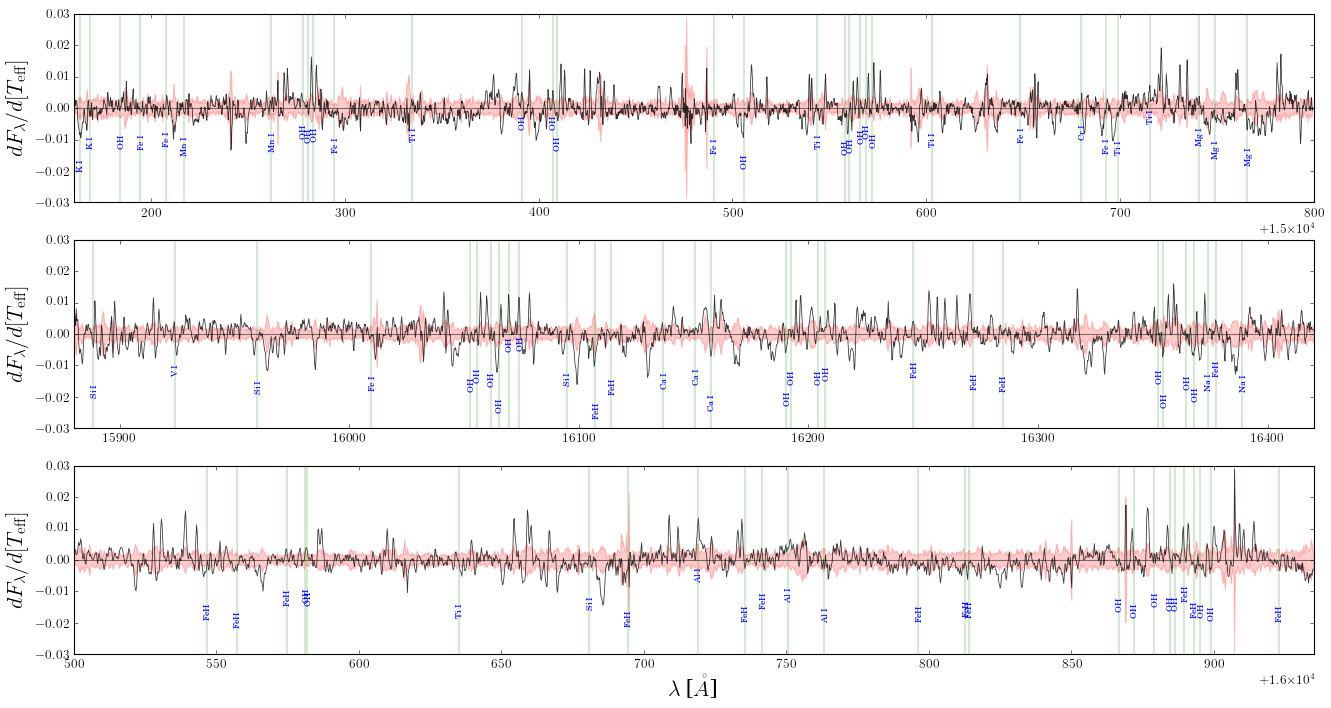

In [133]:
bands = [[15160,15800],[15880,16420],[16500,16935]]
pbands = [np.where((ds.wl > bands[0][0]) & (ds.wl < bands[0][1]))[0], \
    np.where((ds.wl > bands[1][0]) & (ds.wl < bands[1][1]))[0], \
    np.where((ds.wl > bands[2][0]) & (ds.wl < bands[2][1]))[0]]

k = 3
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax1.set_xlim(bands[0])
ax1.legend(loc='upper right')

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_teff, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[T_{\rm eff}]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
        ypos = flux[index]
        plot_ypos_min = (ypos - yrange[0] +1)/(yrange[1] - yrange[0])
        plot_ypos_max = (ypos - yrange[0] -1)/(yrange[1] - yrange[0])

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax1.text(feature, ypos-.01, lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax2.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax3.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

plt.ylim(-.03,.03)
plt.show()

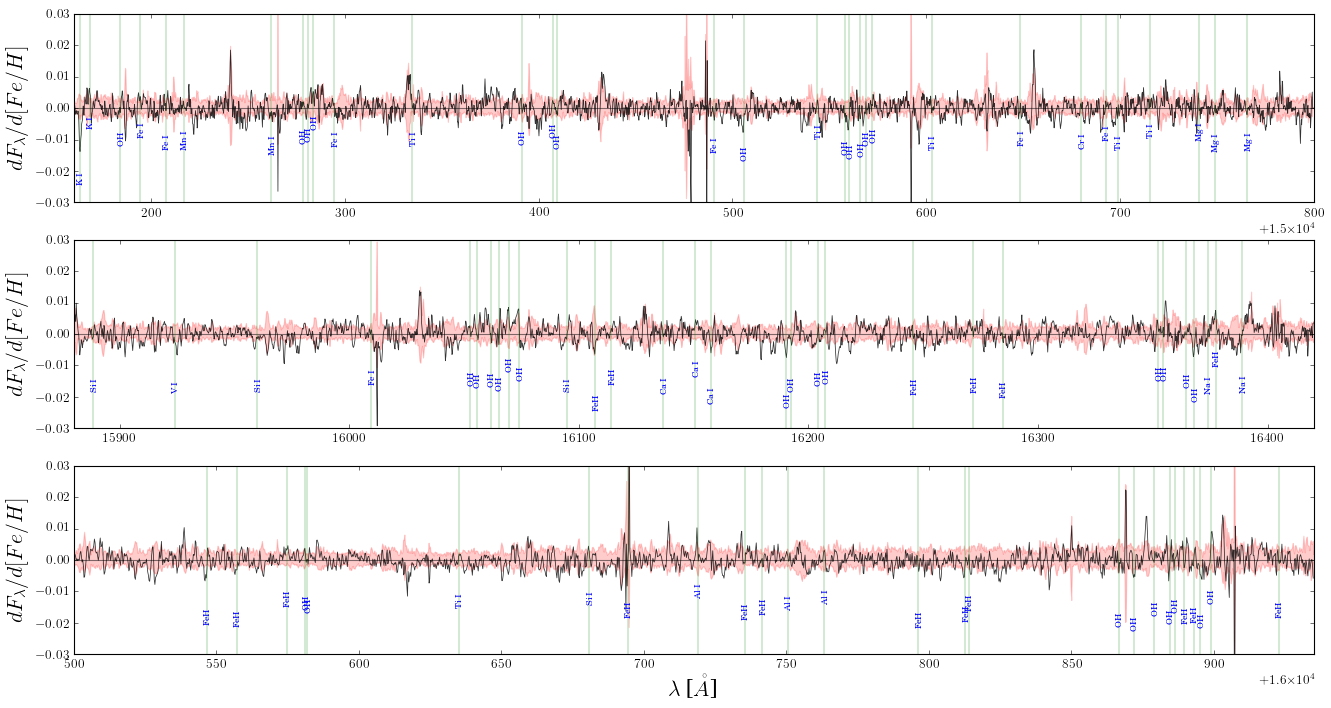

In [132]:
bands = [[15160,15800],[15880,16420],[16500,16935]]
pbands = [np.where((ds.wl > bands[0][0]) & (ds.wl < bands[0][1]))[0], \
    np.where((ds.wl > bands[1][0]) & (ds.wl < bands[1][1]))[0], \
    np.where((ds.wl > bands[2][0]) & (ds.wl < bands[2][1]))[0]]

k = 4
wave = ds.wl
flux = md.coeffs.T[k]

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20,10), facecolor='w', sharey=True)

ax1.plot(ds.wl[pbands[0]], md.coeffs.T[k][pbands[0]], color='k', alpha=.8, linewidth=.7)
ax1.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax1.axhline(y=0, color='k', alpha=.5)
ax1.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax1.set_xlim(bands[0])
ax1.legend(loc='upper right')

ax2.plot(ds.wl[pbands[1]], md.coeffs.T[k][pbands[1]], color='k', alpha=.8, linewidth=.7)
ax2.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax2.axhline(y=0, color='k', alpha=.5)
ax2.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax2.set_xlim(bands[1])

ax3.plot(ds.wl[pbands[2]], md.coeffs.T[k][pbands[2]], color='k', alpha=.8, linewidth=.7)
ax3.fill_between(ds.wl, -jack_err_teff, jack_err_fe_h, alpha=.2, color='r')
ax3.axhline(y=0, color='k', alpha=.5)
ax3.set_ylabel(r'$dF_{\lambda}/d[Fe/H]$', fontsize=20)
ax3.set_xlabel(r'$\lambda$ [$\mathring{A}$]', fontsize=20)
ax3.set_xlim(bands[2])

xrange = [ds.wl[0], ds.wl[1]]
yrange = [min(md.coeffs.T[k]), max(md.coeffs.T[k])]

for lines in line_names:
    for feature in line_list[lines]:

        # determine position of the line and label based on pixel of the spectrum
        xpos = min(wave, key=lambda x:abs(x - feature))
        index = list(wave).index(xpos)
        ypos = flux[index]
        plot_ypos_min = (ypos - yrange[0] +1)/(yrange[1] - yrange[0])
        plot_ypos_max = (ypos - yrange[0] -1)/(yrange[1] - yrange[0])

        if (feature >= bands[0][0]) & (feature <= bands[0][1]):
            ax1.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax1.text(feature, ypos-.01, lines, rotation=90, ha='center', color='b', fontsize=8)
       
        elif (feature >= bands[1][0]) & (feature <= bands[1][1]):
            ax2.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax2.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

        elif (feature >= bands[2][0]) & (feature <= bands[2][1]):
            ax3.axvline(x=feature, ymin=plot_ypos_min, ymax=plot_ypos_max, linewidth=.3, color='g')
            ax3.text(feature, ypos-.015, lines, rotation=90, ha='center', color='b', fontsize=8)

plt.ylim(-.03,.03)
plt.show()

array([0., 0., 0., ..., 0., 0., 0.])